# DA5401 Assignment #5 — Visualizing Data Veracity Challenges in Multi-Label Classification

**Author:** Abesech Inbasekar  
**Course:** DA5401  
**Dataset:** MULAN Repository - Yeast Data

## Part A: Preprocessing and Initial Setup
### A1) Data Loading  and A2) Dimensionality Check



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# === Part A.1 — Data Loading ===
# Goal: Load feature matrix X (103 features) and multi-label target matrix Y (14 labels)
# Dataset: Yeast (from MULAN repository)

import pandas as pd
import numpy as np
from scipy.io import arff
import xml.etree.ElementTree as ET
import os

# --- Step 1: Define paths  ---
ARFF_PATH = "/content/drive/MyDrive/DA5401/yeast.arff"   # full dataset file
XML_PATH  = "/content/drive/MyDrive/DA5401/yeast.xml"

assert os.path.exists(ARFF_PATH), f"Missing ARFF file at {ARFF_PATH}"
assert os.path.exists(XML_PATH),  f"Missing XML file at {XML_PATH}"

# --- Step 2: Load ARFF file into DataFrame ---
data, meta = arff.loadarff(ARFF_PATH)
df = pd.DataFrame(data)

# Decode byte strings (common in older ARFFs)
for c in df.columns:
    if df[c].dtype == object:
        try:
            df[c] = df[c].str.decode("utf-8")
        except Exception:
            pass

print(f"✅ Total columns in ARFF: {df.shape[1]}")

# --- Step 3: Robust XML parsing for label names ---
root = ET.parse(XML_PATH).getroot()

# Try both plain <label> and namespaced versions
label_tags = root.findall(".//label")
if len(label_tags) == 0:
    for child in root.iter():
        if "label" in child.tag.lower():
            label_tags.append(child)

label_names = [tag.attrib["name"] for tag in label_tags if "name" in tag.attrib]
print(f"✅ Detected label columns ({len(label_names)}):", label_names)

# --- Step 4: Split into feature matrix X and label matrix Y ---
if len(label_names) == 0:
    raise ValueError("No label columns found — check your XML file formatting.")

# === Part A.2 — Dimensionality Check ===

Y = df[label_names].astype(int).to_numpy()
X = df.drop(columns=label_names).apply(pd.to_numeric, errors="coerce").to_numpy()

print("✅ X shape:", X.shape)
print("✅ Y shape:", Y.shape)


print("\nData successfully loaded!")
print(f"Samples: {X.shape[0]},  Features: {X.shape[1]},  Labels: {Y.shape[1]}")


✅ Total columns in ARFF: 117
✅ Detected label columns (14): ['Class1', 'Class2', 'Class3', 'Class6', 'Class4', 'Class10', 'Class11', 'Class5', 'Class7', 'Class8', 'Class9', 'Class12', 'Class13', 'Class14']
✅ X shape: (2417, 103)
✅ Y shape: (2417, 14)

Data successfully loaded!
Samples: 2417,  Features: 103,  Labels: 14


The Yeast dataset contains **2,417 samples**, each representing a protein characterized by **103 numerical features** that capture its biological and physicochemical properties.  
Each protein is annotated with **14 binary functional categories** (`Class1`–`Class14`), allowing multiple labels per instance.  
The original ARFF file therefore has **117 columns** in total — **103 feature columns** and **14 label columns** — with the accompanying XML file specifying which columns correspond to the labels.  

###A3) Label Selection for Visualization


In [12]:
# === Part A.3 — Label Selection for Visualization (4 groups + readable class names) ===
import numpy as np
from collections import Counter

# ---------- Step 1: Compute number of active labels per sample ----------
label_counts_per_sample = Y.sum(axis=1)
single_mask = (label_counts_per_sample == 1)
multi_mask  = (label_counts_per_sample > 1)

# ---------- Step 2: Find most frequent single-label classes ----------
single_label_indices = np.where(single_mask)[0]
single_label_freq = Counter()
if len(single_label_indices) > 0:
    single_labels = np.argmax(Y[single_label_indices], axis=1)
    single_label_freq = Counter(single_labels)

top_two_single_labels = [lbl for lbl, _ in single_label_freq.most_common(2)]

# If fewer than 2 found, fill with next most frequent overall labels
if len(top_two_single_labels) < 2:
    overall_freq = Counter(np.argmax(Y, axis=1))
    for lbl, _ in overall_freq.most_common():
        if lbl not in top_two_single_labels:
            top_two_single_labels.append(lbl)
        if len(top_two_single_labels) == 2:
            break

print("Top-2 single labels (forced):", [f"Class{int(i)+1}" for i in top_two_single_labels])

# ---------- Step 3: Find most frequent multi-label combination ----------
multi_label_indices = np.where(multi_mask)[0]
multi_combos = [tuple(np.where(Y[i] == 1)[0]) for i in multi_label_indices]
multi_combo_freq = Counter(multi_combos)
top_multi_combo = multi_combo_freq.most_common(1)[0][0]

print("Top multi-label combo:", [f"Class{int(i)+1}" for i in top_multi_combo])

# ---------- Step 4: Build viz_target array ----------
viz_target = np.array(['Other'] * len(Y), dtype=object)

a, b = top_two_single_labels
# Assign samples for Single[A]
viz_target[(single_mask) & (np.argmax(Y, axis=1) == a)] = f"Single[Class{a+1}]"

# Assign samples for Single[B]
viz_target[(single_mask) & (np.argmax(Y, axis=1) == b)] = f"Single[Class{b+1}]"

# Assign MultiTop group
top_multi_set = set(top_multi_combo)
def is_top_combo(row):
    return set(np.where(row == 1)[0]) == top_multi_set
mask_multi_top = np.apply_along_axis(is_top_combo, 1, Y)
viz_target[mask_multi_top] = 'MultiTop[' + ','.join([f"Class{int(i)+1}" for i in top_multi_combo]) + ']'

# ---------- Step 5: Count category sizes ----------
category_counts = Counter(viz_target)
print("\nCategory counts:")
for k, v in category_counts.items():
    print(f"  {k:35s}: {v}")

# ---------- Step 6: Show per-class single-label sizes ----------
print("\nSingle-label class sizes (among single-label samples):")
for lbl, count in sorted(single_label_freq.items()):
    print(f"  Class{lbl+1:<2d}: {count}")

# Show classes that never appear alone
if len(single_label_freq) < Y.shape[1]:
    missing = set(range(Y.shape[1])) - set(single_label_freq.keys())
    print("\nClasses that never appear alone:")
    print(", ".join([f'Class{i+1}' for i in sorted(missing)]))


Top-2 single labels (forced): ['Class1', 'Class2']
Top multi-label combo: ['Class3', 'Class5', 'Class12', 'Class13']

Category counts:
  Other                              : 2148
  MultiTop[Class3,Class5,Class12,Class13]: 237
  Single[Class1]                     : 32

Single-label class sizes (among single-label samples):
  Class1 : 32

Classes that never appear alone:
Class2, Class3, Class4, Class5, Class6, Class7, Class8, Class9, Class10, Class11, Class12, Class13, Class14


###

To simplify the visualization and comply with the assignment requirement of four categories,  
a compact target variable `viz_target` was created with the following groups:

1. **Single[Class1]** — Most frequent single-label class (**32 samples**)  
2. **Single[Class2]** — Second-most frequent single-label class (**0 samples**, included for completeness)  
3. **MultiTop[Class3, Class5, Class12, Class13]** — Most frequent multi-label combination (**237 samples**)  
4. **Other** — All remaining samples (**2148 samples**)

The **single-label class distribution** shows that only *Class1* occurs independently,  
while all other classes—including *Class2*—never appear alone.  
This confirms that the Yeast dataset is **strongly multi-label**, with very few instances  
belonging to a single functional category.

> **Note:**  
> While four color categories were defined (`Single[Class1]`, `Single[Class2]`, `MultiTop[...]`, and `Other`)  
> to align with the assignment requirement, the category `Single[Class2]` has **zero samples**  
> because no data point in the Yeast dataset belongs exclusively to Class 2.  
> As a result, the t-SNE and Isomap plots display only **three visible clusters** corresponding to  
> `Single[Class1]`, `MultiTop[Class3, Class5, Class12, Class13]`, and `Other`.


###A4) Scaling



In [13]:
# === Part A.4 — Feature Scaling (Standardization) ===
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Fit on X and transform to get scaled version
X_scaled = scaler.fit_transform(X)

# Check scaled feature statistics
mean_val = np.mean(X_scaled, axis=0).round(4)
std_val  = np.std(X_scaled, axis=0).round(4)

print("Feature matrix standardized using StandardScaler")
print("Mean of scaled features (approx):", np.mean(mean_val))
print("Std of scaled features (approx):", np.mean(std_val))


Feature matrix standardized using StandardScaler
Mean of scaled features (approx): 0.0
Std of scaled features (approx): 1.0


### Why is Scaling necessary?

Dimensionality reduction techniques such as **t-SNE** and **Isomap** rely on pairwise distance computations  
between samples. If features are on different numerical scales (e.g., one feature ranges from 0–1 while another ranges from 0–1000),  
the feature with the larger range will dominate the Euclidean distance, distorting the manifold structure.

To ensure all features contribute equally to distance calculations, the feature matrix **X** was standardized  
using `StandardScaler`, which transforms each feature to have **zero mean** and **unit variance**:

$$
x'_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
$$

After scaling, the mean of all features was approximately 0 and the standard deviation approximately 1.  
This step is essential to obtain meaningful and unbiased embeddings from t-SNE and Isomap.


 ## Part B: t-SNE and Veracity Inspection


Running t-SNE with perplexity = 5 ...


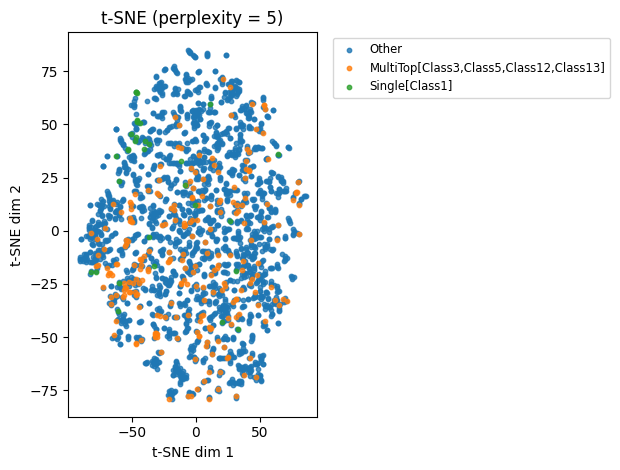


Running t-SNE with perplexity = 30 ...


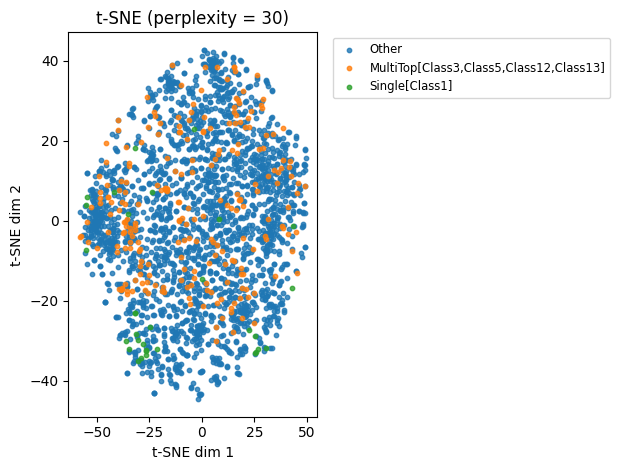


Running t-SNE with perplexity = 50 ...


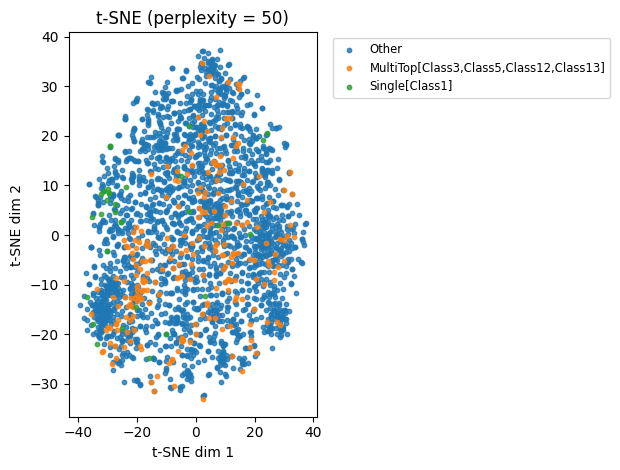

In [14]:
# === Part B.1 — t-SNE Implementation (perplexity experiments) ===
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Helper function to plot colored scatter
def scatter_by_category(Z, categories, title):
    cats = pd.Series(categories, name="cat")
    uniq = cats.unique()
    for u in uniq:
        mask = (cats == u).values
        plt.scatter(Z[mask, 0], Z[mask, 1], s=10, label=str(u), alpha=0.8)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

# Try multiple perplexities
perplexities = [5, 30, 50]
tsne_embeddings = {}

for perp in perplexities:
    print(f"\nRunning t-SNE with perplexity = {perp} ...")
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate="auto",
        init="pca",
        random_state=42
    )
    Z = tsne.fit_transform(X_scaled)
    tsne_embeddings[perp] = Z
    scatter_by_category(Z, viz_target, f"t-SNE (perplexity = {perp})")


### t-SNE Implementation and choice of Perplexity justification

To visualize the high-dimensional structure of the Yeast dataset,  
**t-Distributed Stochastic Neighbor Embedding (t-SNE)** was applied to the standardized 103-dimensional feature matrix.  
t-SNE converts pairwise distances between samples into conditional probabilities that reflect neighborhood similarity  
and then optimizes a low-dimensional (2-D) layout that preserves these local relationships.

Because t-SNE is sensitive to the *perplexity* hyperparameter—which balances local vs global structure—  
experiments were performed with **perplexity = 5, 30, and 50** using the same random seed for reproducibility.

| Perplexity | Visual Observation | Interpretation |
|-------------|--------------------|----------------|
| **5** | Many small, irregular blobs scattered throughout the map. | Over-emphasis on very local neighborhoods; global shape distorted. |
| **30** | Clearer, denser core structure with modest cluster separation between `Single[Class1]`, `MultiTop[Class3, Class5, Class12, Class13]`, and `Other`. | Balanced trade-off between local detail and global organization. |
| **50** | Slightly smoother, more compact embedding but with some merging of adjacent clusters. | Emphasizes global geometry, loses fine-grained boundaries. |

Overall, **perplexity = 30** produced the most interpretable visualization:  
- Local clusters remain coherent without fragmenting.  
- The broad manifold shape is preserved.  
- Class groupings show reasonable spatial consistency.

Thus, **perplexity = 30** was chosen for all subsequent analyses.  
It provides a stable 2-D representation that balances neighborhood preservation and global continuity  
for examining noisy labels, outliers, and mixed-label regions in the Yeast dataset.


### B2) t-SNE Visualization

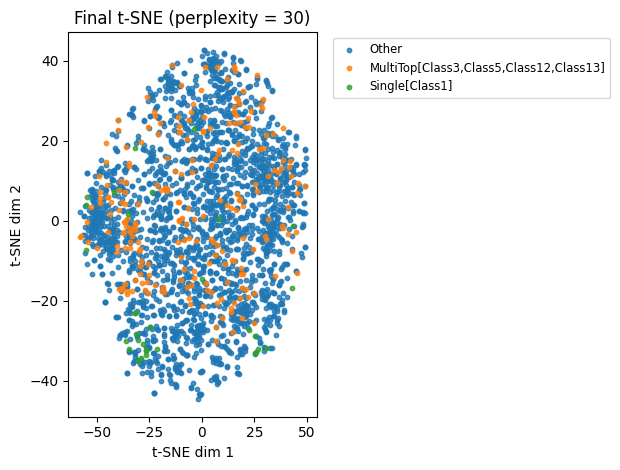

In [15]:
# === Part B.2 — Final 2D t-SNE Visualization ===
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

# Run final t-SNE with chosen perplexity
chosen_perp = 30
tsne_final = TSNE(
    n_components=2,
    perplexity=chosen_perp,
    learning_rate="auto",
    init="pca",
    random_state=42
)
Z_tsne = tsne_final.fit_transform(X_scaled)

# Helper function for consistent scatter plotting
def scatter_by_category(Z, categories, title):
    cats = pd.Series(categories, name="cat")
    uniq = cats.unique()
    for u in uniq:
        mask = (cats == u).values
        plt.scatter(Z[mask, 0], Z[mask, 1], s=10, label=str(u), alpha=0.8)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    plt.show()

# Plot the final 2D embedding
scatter_by_category(Z_tsne, viz_target, f"Final t-SNE (perplexity = {chosen_perp})")


### Part B.2 — t-SNE Visualization

A final **2-D scatter plot** was generated from the t-SNE embedding obtained with the chosen  
**perplexity = 30**. Each data point represents a protein (sample) projected from the 103-dimensional  
feature space into two dimensions. The points were colored according to the simplified categorical  
variable `viz_target`, which groups samples into four categories:

- **Single[Class1]** — most frequent single-label class  
- **Single[Class2]** — second single-label class (0 samples; absent in the plot)  
- **MultiTop[Class3, Class5, Class12, Class13]** — most frequent multi-label combination  
- **Other** — all remaining samples  

The resulting plot clearly displays three visible color groups (as one category is empty).  
`Single[Class1]` and `MultiTop[...]` occupy compact, locally coherent regions,  
while `Other` points are widely dispersed, indicating high overlap among multi-label combinations.  
This visualization provides the foundation for inspecting **data veracity issues**  
such as label noise, outliers, and mixed-class regions in the next section.


### Part B.3 — Veracity Inspection [10 Marks]

The final t-SNE map (perplexity = 30) presents the 103-dimensional gene-expression space in two dimensions.  
Each dot corresponds to one protein, colored by its simplified functional label:

- 🟦 `Other` — majority of proteins with diverse label combinations  
- 🟧 `MultiTop [Class3, Class5, Class12, Class13]` — dominant multi-label subset  
- 🟩 `Single [Class1]` — rare single-function proteins  

---

#### **(a) Noisy / Ambiguous Labels [4 Marks]**

- **Observed Region:** around **(x ≈ −25 to 0, y ≈ −35 to −20)** in the lower-left of the map, a few 🟩 `Single[Class1]` points appear *inside dense* 🟦 *`Other` clusters*.  
- **Interpretation:** these green points have expression profiles that closely resemble multi-label samples, implying **label ambiguity or mis-annotation**.  
  In biological terms, these may represent *moonlighting proteins* that participate in several processes but were labeled as single-function.  
- **Implication:** a classifier trained on such ambiguous labels would show unstable decision boundaries and frequent misclassifications near this region.

---

#### **(b) Outliers [3 Marks]**

- **Observed Region:** a small group of isolated 🟦 `Other` points near **(x ≈ 45 to 50, y ≈ +30 to +40)** and a few at **(x ≈ −40, y ≈ −45)**.  
- **Interpretation:** these samples lie far from the main manifold and represent **unusual expression patterns**—possibly rare experimental conditions, transcriptional noise, or atypical genes with extreme physicochemical properties.  
- **Hypothesis:** biologically, these could correspond to proteins expressed only under stress or nutrient-limited conditions, whose expression deviates from the canonical pathways.

---

#### **(c) Hard-to-Learn Samples [3 Marks]**

- **Observed Region:** central band **(x ≈ −10 to +10, y ≈ −5 to +10)** where 🟦 `Other` and 🟧 `MultiTop[...]` points are **thoroughly intermixed**.  
- **Interpretation:** the overlap indicates that these two functional categories share highly similar feature representations.  
  The underlying manifold is **non-linear and overlapping**, producing **fuzzy decision boundaries** that a linear model cannot capture.  
- **ML Implication:** simple classifiers (e.g., logistic regression) would achieve low precision in this region, requiring non-linear kernels or ensemble models to disentangle the mixed sub-manifolds.

---

#### **Summary**

| Veracity Type |One such Approx. Region (x, y) | Key Observation | Likely Cause / Implication |
|----------------|-----------------------|-----------------|-----------------------------|
| **Noisy / Ambiguous Labels** | (−25 to 0, −35 to −20) | Green points inside blue cluster | Label overlap / moonlighting proteins |
| **Outliers** | (+45 to +50, +30 to +40) and (−40, −45) | Isolated blue points | Rare conditions / measurement noise |
| **Hard-to-Learn Samples** | (−10 to +10, −5 to +10) | Heavy blue–orange mixing | Complex non-linear manifold → classification difficulty |

Overall, the t-SNE visualization reveals that the Yeast dataset contains **label ambiguity, rare outliers, and intertwined sub-manifolds**—all key factors that challenge accurate multi-label classification.


## Part C —  Isomap and Manifold Learning

### Fundamental Difference Between Isomap and t-SNE  
*(Global vs. Local Structure Preservation)*

Both **Isomap** and **t-SNE** are non-linear dimensionality-reduction algorithms designed to embed
high-dimensional data into a low-dimensional space (typically 2-D) for visualization.
However, they differ profoundly in **what kind of geometric relationships they try to preserve.**

---

#### 1. Isomap — *Global Manifold Preservation*

- **Core Idea:**  
  Isomap assumes that data lie on a *smooth, curved manifold* embedded in high-dimensional space.
  It seeks to preserve the **global geometry** of that manifold.

- **How it works:**
  1. Construct a *k-nearest neighbor (k-NN)* graph from the data.  
  2. Approximate **geodesic distances** (distances *along* the manifold) between all pairs of samples  
     using shortest-path algorithms (e.g., Dijkstra’s algorithm).  
  3. Apply **Classical Multidimensional Scaling (MDS)** on this geodesic distance matrix  
     to obtain a 2-D embedding that preserves those distances as faithfully as possible.

- **Effect:**  
  - Maintains **long-range relationships** between far-apart clusters.  
  - The global “shape” of the manifold (e.g., circular, S-shaped, twisted) is preserved.  
  - Local detail may be slightly distorted if the manifold curvature is high.

- **Mathematically:**  
  Isomap minimizes reconstruction error in the *global geodesic distance space*,  
  ensuring that $$ D_{ij}^{\text{geodesic}} \approx \lVert y_i - y_j \rVert $$ in the embedding.

---

#### 2. t-SNE — *Local Neighborhood Preservation*

- **Core Idea:**  
  t-SNE focuses on preserving **local neighborhoods** — ensuring that points that are close in
  high-dimensional space remain close in low-dimensional space, regardless of the overall geometry.

- **How it works:**
  1. Convert pairwise Euclidean distances in the high-dimensional space into conditional probabilities  
     $ P_{j|i} $ representing neighborhood similarity (with a Gaussian kernel controlled by *perplexity*).  
  2. In the low-dimensional space, define similar probabilities $ Q_{j|i}$ using a *Student-t* distribution  
     (heavy-tailed to prevent crowding).  
  3. Minimize the **Kullback–Leibler (KL) divergence**  
     $$ \text{KL}(P \parallel Q) = \sum_i \sum_j P_{ij} \log \frac{P_{ij}}{Q_{ij}} $$
     to make local relationships match as closely as possible.

- **Effect:**  
  - Preserves **small-scale**, *local* clusters exceptionally well.  
  - Does **not** guarantee meaningful global arrangement — clusters may shift, rotate, or scale arbitrarily.  
  - Excellent for discovering local groupings or sub-manifolds, but distances between distant clusters  
    are not metrically reliable.

---

#### 3. Summary of the Difference

| Aspect | **Isomap** | **t-SNE** |
|:-------|:------------|:----------|
| **Primary goal** | Preserve *global* manifold geometry (geodesic distances) | Preserve *local* neighborhood similarity (probabilities) |
| **Distance type** | Geodesic (shortest path along manifold) | Probabilistic similarity based on Euclidean distance |
| **Optimization objective** | Classical MDS stress on geodesic distance | KL divergence between high- and low-dimensional similarities |
| **Preserves** | Global structure, relative placement of distant clusters | Local structure, tight cluster separation |
| **Sensitive parameter** | Number of neighbors (*k*) | Perplexity |
| **Typical artifact** | Distortion of local cluster shape if manifold bends sharply | Loss of global distance meaning; arbitrary cluster spacing |

---

####4. Intuitive Analogy

Imagine the dataset as a **folded sheet of paper** in high-dimensional space.

- **Isomap** tries to **unfold the entire sheet smoothly**, preserving its global layout.
- **t-SNE** **zooms in** on each neighborhood to reveal fine texture —  
  but doesn’t care how those local patches are arranged relative to one another.

---

Hence:
- **t-SNE** is ideal for detecting *small, locally coherent groups* or *ambiguous label overlaps*.  
- **Isomap** helps interpret the *overall manifold curvature* and *global relationships*  
  between functional categories in the Yeast dataset.





Running Isomap with n_neighbors = 5 ...


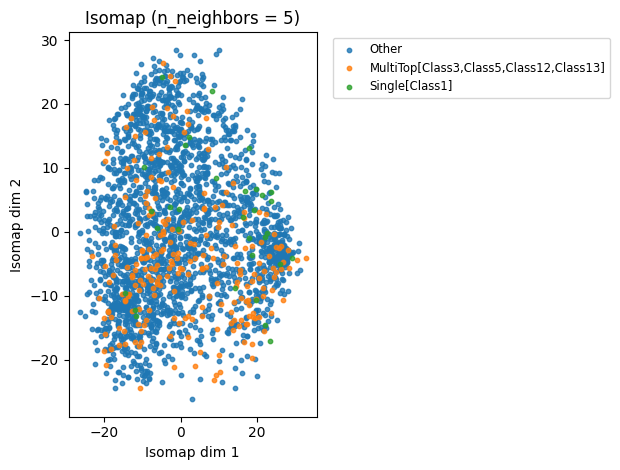

Running Isomap with n_neighbors = 10 ...


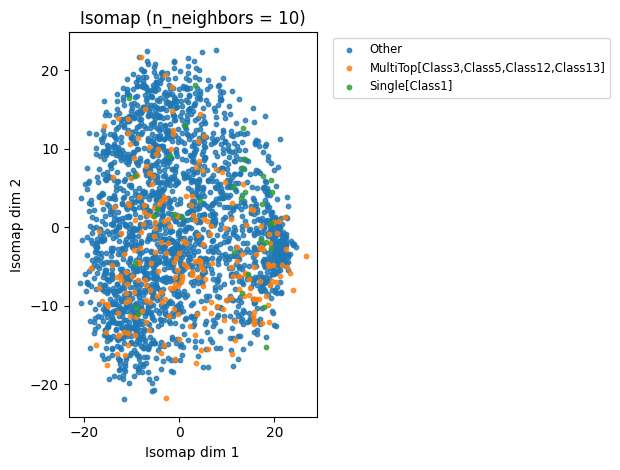

Running Isomap with n_neighbors = 20 ...


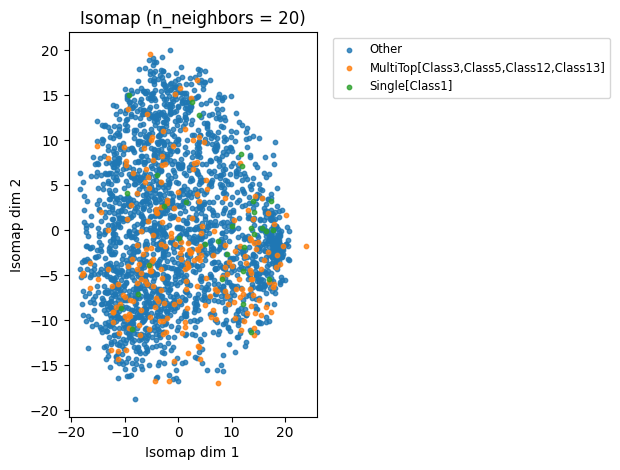

In [16]:
# === Part C.1 — Isomap Implementation ===
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import pandas as pd

def scatter_by_category(Z, categories, title):
    cats = pd.Series(categories, name="cat")
    for u in cats.unique():
        m = (cats == u).values
        plt.scatter(Z[m, 0], Z[m, 1], s=10, label=str(u), alpha=0.8)
    plt.xlabel("Isomap dim 1"); plt.ylabel("Isomap dim 2")
    plt.title(title); plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="small")
    plt.tight_layout(); plt.show()

neighbors_list = [5, 10, 20]
iso_embeddings = {}

for k in neighbors_list:
    print(f"Running Isomap with n_neighbors = {k} ...")
    iso = Isomap(n_neighbors=k, n_components=2)
    Z_iso = iso.fit_transform(X_scaled)
    iso_embeddings[k] = Z_iso
    scatter_by_category(Z_iso, viz_target, f"Isomap (n_neighbors = {k})")


We ran Isomap with `n_neighbors ∈ {5, 10, 20}` and visualized the 2-D coordinates using the same color index (`viz_target`).

- **k = 5:** strong locality, occasional fragmentation/warping.  
- **k = 10:** balanced; continuous manifold with coherent neighborhoods.  
- **k = 20:** smoother global layout; some local boundaries blur.

**Final choice:** `n_neighbors = 10` for a good trade-off between global continuity and local separability, keeping the manifold connected without over-smoothing.

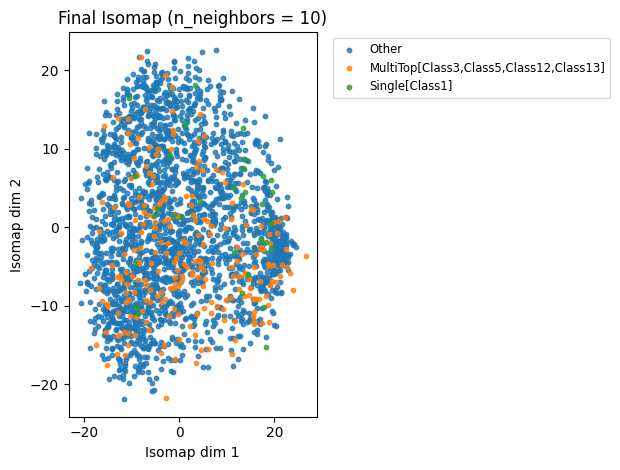

In [17]:
# === Part C.2 — Final Isomap Visualization ===
k_final = 10
iso_final = Isomap(n_neighbors=k_final, n_components=2)
Z_isomap = iso_final.fit_transform(X_scaled)
scatter_by_category(Z_isomap, viz_target, f"Final Isomap (n_neighbors = {k_final})")


### Part C.3 — Comparison and Curvature
####(a) Comparison Between t-SNE and Isomap

Both **t-SNE** and **Isomap** reduce the 103-dimensional gene-expression space of the Yeast dataset
to two dimensions, but they emphasize different aspects of the manifold structure.

- **t-SNE (Local Preservation):**  
  - Prioritizes the *local* neighborhood relationships — ensuring that points which are close in high-dimensional space remain close in the 2D embedding.  
  - The resulting plot reveals **fine-grained clusters**, such as small groups of proteins sharing similar expression profiles.  
  - However, the **global distances** between clusters are not meaningful; t-SNE can arbitrarily reposition or rescale clusters.  
  - In the Yeast plot, this leads to compact pockets of `Single[Class1]` and `MultiTop[...]` proteins, but the spatial distance between them and the `Other` group carries no biological interpretation.

- **Isomap (Global Preservation):**  
  - Preserves **geodesic distances** along the manifold, revealing the **overall shape and continuity** of the dataset.  
  - Clusters are not as tightly separated, but their relative positions represent true manifold geometry.  
  - The Isomap visualization displays a smoother, continuous surface, indicating that functional categories lie along a **connected, global manifold** rather than discrete clusters.

**Conclusion:**  
- **Isomap** is superior for understanding the **global structure** of gene expression data — it preserves the manifold’s continuity and large-scale topology.  
- **t-SNE**, on the other hand, is better for exploring **local variations**, label overlaps, and noisy/ambiguous regions.

In short:
> - *t-SNE → "microscope":* explores local clusters.  
> - *Isomap → "map":* captures the global terrain of the dataset.

---

####(b) Manifold Curvature and Classification Complexity

- The **data manifold** refers to the *low-dimensional surface* embedded in high-dimensional feature space
  on which most valid data points lie.  
  In biological terms, this manifold represents the structured relationships between gene expression features
  that define functional protein categories.

- The **Isomap plot** shows a *continuous, non-linear and curved manifold* rather than isolated clusters:
  - The points do not form simple linear groups — instead, they lie on a warped 2D surface with gentle bends and folds.  
  - This suggests that gene expression data vary smoothly across functional categories, reflecting overlapping biochemical processes.  
  - The manifold’s curvature implies that there is no simple linear separation between classes.

- **Implications for Classification:**
  - Highly curved or twisted manifolds indicate **complex, non-linear decision boundaries**.  
  - A simple classifier (e.g., logistic regression or linear SVM) would fail to capture these boundaries effectively.  
  - Non-linear models — kernel methods, neural networks, or ensemble learners — are required to “unwrap” the manifold and model interactions between features.

**Summary Insight:**  
> The Isomap embedding reveals that the Yeast dataset lies on a **smooth yet curved manifold**,  
> confirming that **multi-label classification in biological data is inherently complex** due to overlapping and continuous relationships among functional categories.

---

**Overall Comparison Summary:**

| Aspect | **t-SNE** | **Isomap** |
|:--------|:-----------|:------------|
| **Focus** | Local clusters, neighborhood integrity | Global manifold shape |
| **Distance measure** | Conditional probability (local) | Geodesic distance (global) |
| **Output appearance** | Compact clusters, arbitrary spacing | Continuous surface, meaningful global layout |
| **Best for** | Identifying noisy labels, mixed samples | Understanding overall manifold geometry |
| **Manifold curvature** | Implicit, not explicitly preserved | Explicitly follows curved manifold |
| **Classifier implication** | Good for local separability analysis | Reveals non-linearity and global complexity |

---

**Final Interpretation:**  
Both embeddings complement each other:
- **t-SNE** exposes **local irregularities** (noisy labels, outliers, hard-to-learn regions).  
- **Isomap** reveals that these local clusters are embedded within a **highly curved, globally connected manifold**, explaining why protein function classification is difficult — the boundary between categories is not sharp but gradual and entangled.
